# Classification

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/riccardoberta/machine-learning/blob/master/01-introduction/03-classification.ipynb)


The classification modeling is the task of approximating the mapping function from input variables to discrete output variables and the main goal is to identify which class/category the new data will fall into.

1. [Dataset](#Dataset)
2. [Training a classifier](#Training-a-classifier)
3. [Performance Measure](#Performance-Measure)
    - [Accuracy](#Accuracy)
    - [Confusion Matrix, Precision, Recall and F Score](#Confusion-Matrix-Precision-Recall-and-F-Score)
    - [ROC Curve](#ROC-Curve)
4. [Multi Classification](#Multi-Classification)
    - [Multiclass Classification](#Multiclass-Classification)
    - [Multilabel Classification](#Multilabel-Classification)
    - [Multioutput Classification](#Multioutput-Classification)
5. [Exercise](#Exercise)

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

## Dataset
We will be using the MNIST dataset, which is a set of **70,000 small images of digits handwritten** by high school students and employees of the US Census Bureau. Each image is labeled with the digit it represents. This set has been studied so much that it is often called the “hello world” of ML.

Eeach image has 784 features (28 × 28 pixels), and each feature simply represents one pixel’s intensity, from 0 (white) to 255 (black).

Scikit-Learn provides the **fetch_openml()** helper functions to download popular datasets, also MNIST is one of them. The loaded datasets have a similar dictionary
structure, including the following:
- **DESCR** key describing the dataset
- **data** key containing an array with one row per instance and one column per feature
- **target** key containing an array with the labels

In [7]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)

In [8]:
print(mnist.keys())

X = mnist["data"]
y = mnist["target"]
y = y.astype(np.uint8)

print(X.shape)
print(y.shape)

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])
(70000, 784)
(70000,)


Let’s take a peek at one digit from the dataset: grab an instance’s feature vector, **reshape** it to a 28 × 28 array, and display it using Matplotlib’s **imshow()** function:


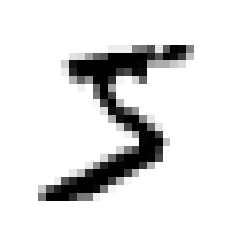

5


In [9]:
some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

print(y[0])

Plot some more examples:

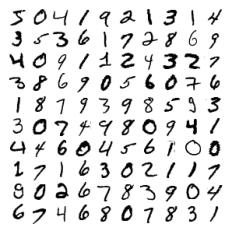

In [10]:
instances = X[:100]
images_per_row = 10
n_rows = len(instances) // images_per_row
images = [instance.reshape(28,28) for instance in instances]
row_images = []
n_images = n_rows * images_per_row
images.append(np.zeros((28, 28 * n_images)))
for row in range(n_rows):
    rimages = images[row * images_per_row : (row + 1) * images_per_row]
    row_images.append(np.concatenate(rimages, axis=1))
image = np.concatenate(row_images, axis=0)
plt.imshow(image, cmap = mpl.cm.binary)
plt.axis("off")
plt.show()

But wait! You should always create a test set and set it aside before inspecting the data closely. The MNIST dataset is actually already split into a **training set** (the first 60,000 images) and a **test set** (the last 10,000 images)

In [11]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

The training set is already shuffled, which is good because this guarantees that all cross-validation folds will be similar (you don’t want one fold to be missing some digits). Moreover, some learning algorithms are sensitive to the order of the training instances, and they perform poorly if they get many similar instances in a row. 

## Training a classifier
Let’s simplify the problem and try to identify one digit (5). This detector will be an example of a **binary classifier**, capable of distinguishing between just two classes (5 and not 5).

A good place to start is with a **Stochastic Gradient Descent (SGD)** (Scikit-Learn’s
**SGDClassifier** class). This classifier has the advantage of being capable of handling very large datasets efficiently (it deals with training instances independently, one at a time). It relies on **randomness** during training (“stochastic”), to get reproducible results, we set the random_state parameter.

In [12]:
from sklearn.linear_model import SGDClassifier

y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

Now we can use it to detect images of the number 5:

In [13]:
sgd_clf.predict([some_digit])

array([ True])

The classifier guesses that this image represents a 5 (True). Now, let’s evaluate this model’s performance.

## Performance Measure
Evaluating a classifier is often significantly trickier than evaluating a regressor. There are many performance measures available.

### Accuracy
Informally, **accuracy** is the fraction of predictions our model got right. Formally, accuracy has the following definition: number of correct predictions / total number of predictions.

In [14]:
def accuracy(tp: int, fp: int, fn: int, tn: int) -> float:
    correct = tp + tn
    total = tp + fp + fn + tn
    return correct / total

We can use **K-fold cross-validation** with three folds, like in the "02_end_to_end_project_example" in order to calculate the accuracy. Remember that it means splitting the training set into K folds, then making predictions and evaluating them on each fold using a model trained on the remaining folds.

In [15]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, 
                X_train, 
                y_train_5, 
                cv=3, 
                scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

Wow! Above 95% **accuracy** (ratio of correct predictions) on all crossvalidation folds? This looks amazing, doesn’t it? Well, before you get too excited, let’s look at a very dumb classifier that just classifies every single image in the “not-5” class:

In [16]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
    
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, 
                X_train, 
                y_train_5, 
                cv=3, 
                scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

That’s right, it has over 90% accuracy! 
This is simply because only about 10% of the images are 5s, so if you always guess that an image is not a 5, you will be right about 90% of the time.

This demonstrates why **accuracy is generally not the preferred performance measure for classifiers**, especially when you are dealing with **skewed datasets** (when some classes are much more frequent than others).

### Confusion Matrix Precision Recall and F Score
A much better way to evaluate the performance of a classifier is to look at the **confusion matrix**. The idea is to count the number of times instances of class A are classified as class B.  To compute it, you need a set of predictions so that they can be compared to the actual targets. You can use the **cross_val_predict()** function, it  performs K-fold cross-validation, but it returns the predictions made on each fold, so you get a **clean predictions** (made by a model that never saw the data during training).

In [17]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, 
                                 X_train, 
                                 y_train_5, 
                                 cv=3)

Now we get the confusion matrix using the **confusion_matrix()** function.

In [18]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

Each row represents an actual class, while each column represents a predicted class. 

The first row of this matrix considers non-5 images (the **negative** class): 53,892 were correctly classified as non-5s (they are called **true negatives TN**), while the remaining 687 were wrongly classified as 5s (**false positives FP**). 

The second row considers the images of 5s (the **positive** class): 1,891 were wrongly classified as non-5s (**false negatives FN**), while the remaining 3,530 were correctly classified as 5s (**true positivesTP**). 

A **perfect classifier** would have only true positives and true negatives.

In [19]:
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

Sometimes you may prefer a more concise metric. An interesting one is the **precision** defined as the accuracy of the positive predictions.

$
\begin{align}
precision = \frac{TP}{TP + FP}
\end{align}
$

Precision is used along with another metric named **recall**, which is the ratio of positive instances that are correctly detected by the classifier.

$
\begin{align}
recall = \frac{TP}{TP + FN}
\end{align}
$

<img src="images/confusion_matrix.png" width="600">

In [20]:
def precision(tp: int, fp: int, fn: int, tn: int) -> float:
    return tp / (tp + fp)

def recall(tp: int, fp: int, fn: int, tn: int) -> float:
    return tp / (tp + fn)

Scikit-Learn provides several functions to compute classifier metrics, including precision and recall.

In [21]:
from sklearn.metrics import precision_score, recall_score
print(precision_score(y_train_5, y_train_pred))
print(recall_score(y_train_5, y_train_pred))

0.8370879772350012
0.6511713705958311


It is often convenient to combine precision and recall into a single metric called the **F score**, in particular if you need a simple way to compare two classifiers. The F score is the **harmonic mean** of precision and recall (whereas the regular mean treats all values equally, the harmonic mean gives much more weight to low values).

$
\begin{align}
F_1 = \frac{2}{\frac{1}{precision} + \frac{1}{recall}} = 2 \times \frac{precision \times recall}{precision + recall} = \frac{TP}{TP + \frac{FN+FP}{2}}
\end{align}
$

In [22]:
def f1_score(tp: int, fp: int, fn: int, tn: int) -> float:
    p = precision(tp, fp, fn, tn)
    r = recall(tp, fp, fn, tn)
    return 2 * p * r / (p + r)

In [23]:
from sklearn.metrics import f1_score
print(f1_score(y_train_5, y_train_pred))

0.7325171197343846


The F score favors classifiers that have similar precision and recall. This is not always the case. 

For example, if you need to detect videos that are safe for kids, you probably prefer a classifier that rejects good videos (low recall) but keeps only safe ones (high precision).

On the other hand, suppose you need to detect shoplifters in surveillance images: it is probably fine if your classifier has low precision as long as it has high recall (you will get a few false alerts, but almost all shoplifters will get caught).

Unfortunately, you can’t have it both ways: increasing precision reduces recall, and vice versa. This is called the **precision/recall trade-off**.

The classifier use a decision function: if the score is greater than a threshold, it assigns the instance to the positive class, otherwise it assigns it to the negative class. If you raise the threshold, some false positive becomes a true negative, increasing the precision, but probably some true positives becomes false negatives,
decreasing recall. Conversely, lowering the threshold increases recall and reduces precision.

<img src="images/precision_recall_trade_off.png" width="600">

Scikit-Learn does not let you set the threshold directly, but it gives you access to the **decision scores** that it uses to make predictions using the **decision_function()** method. Then we can use any threshold we want to make predictions.

In [24]:
y_scores = sgd_clf.decision_function([some_digit])
print(y_scores)

threshold = 0
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

threshold = 8000
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

[2164.22030239]
[ True]
[False]


How we decide which threshold to use? 

First, use the cross_val_predict() function to get the scores of all instances in the
training set, but this time specify that you want to return decision scores instead of predictions. Then, use the **precision_recall_curve()** function to compute precision and recall for all possible thresholds. Finally, plot precision and recall as functions of the threshold value.

In [25]:
from sklearn.metrics import precision_recall_curve

y_scores = cross_val_predict(sgd_clf, 
                             X_train, 
                             y_train_5, 
                             cv=3, 
                             method="decision_function")

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

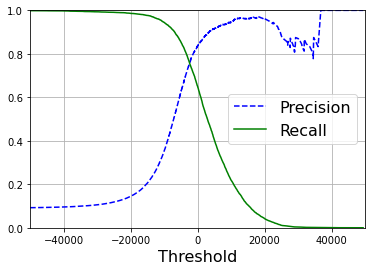

In [26]:
plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
plt.legend(loc="center right", fontsize=16)
plt.xlabel("Threshold", fontsize=16)        
plt.grid(True)                              
plt.axis([-50000, 50000, 0, 1])             
plt.show()

The precision curve can be bumpier than the recall curve becaouse precision may sometimes go down when you raise the threshold (although in general it will go up), on the other hand, recall can only go down when the threshold is increased.

Another way to select a good precision/recall trade-off is to plot precision
directly against recall.

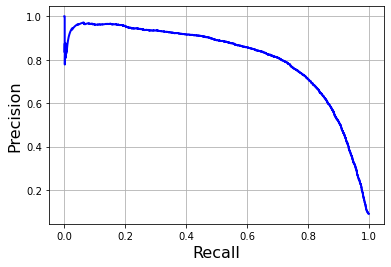

In [27]:
plt.plot(recalls, precisions, "b-", linewidth=2)
plt.xlabel("Recall", fontsize=16)
plt.ylabel("Precision", fontsize=16)
plt.grid(True)
plt.show()

Precision starts to fall sharply around 80% recall. You will probably want to select a precision/recall trade-off just before that drop, for example at around 60% recall. 

But of course, the choice depends on your project, you can search for the lowest threshold that gives you at least 90% precision using the **np.argmax()** function which gives the first index of the maximum value.

In [29]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
print(hold_90_precision)

y_train_pred_90 = (y_scores >= threshold_90_precision)
print(precision_score(y_train_5, y_train_pred_90))
print(recall_score(y_train_5, y_train_pred_90))

3370.0194991439557
0.9000345901072293
0.4799852425751706


As you can see, it is fairly easy **to create a classifier with virtually any precision you want**: just set a high enough threshold, and you’re done. But **at what recall?**

### ROC Curve
The **receiver operating characteristic (ROC)** curve is another common tool
used with binary classifiers. It plots the **true positive rate** (the proportion of positives that are correctly identified, also colled **sensitivity**) against the **false positive rate (FPR)** (1 - the proportion of negatives that are correctly identifie, also called **specificity**)

<img src="images/sensitivity_specificity.png" width="400">

To plot the ROC curve, you first use the **roc_curve()** function to compute
the TPR and FPR for various threshold values. Then you can plot the FPR against the TPR.
 

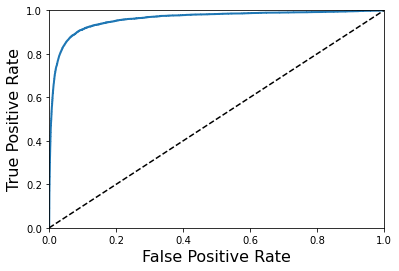

In [30]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], 'k--')
plt.axis([0, 1, 0, 1]) 
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.show()                                            #

Once again there is a trade-off: the higher the TPR, the more false positives (FPR) the classifier produces. The dotted line represents the ROC curve of a purely random classifier; a good classifier stays as far away from that line as possible (toward the top-left corner).

One way to compare classifiers is to measure the **area under the curve** (AUC). A perfect classifier will have a ROC AUC equal to 1, whereas a purely random classifier will have a ROC AUC equal to 0.5. 

Scikit-Learn provides a function to compute the ROC AUC.

In [31]:
from sklearn.metrics import roc_auc_score
print(roc_auc_score(y_train_5, y_scores))

0.9604938554008616


Since the ROC curve is so similar to the precision/recall (PR) curve, how to decide which one to use? 

As a rule of thumb, you should prefer the PR curve whenever the positive class is rare or when you care more about the false positives than the false negatives. Otherwise, use the ROC curve. 

In the example, looking at the ROC curve, you may think that the classifier is really good, but this is mostly because there are few positives compared to the negatives. In contrast, the PR curve makes it clear that the classifier has room for improvement.

## Multi Classification

### Multiclass Classification
**multiclass classifiers** can distinguish between more than two classes.

Some algorithms are capable of handling multiple classes natively, others are strictly binary classifiers. 

However, there are strategies to perform multiclass classification with multiple binary classifiers.

One way is to train N binary classifiers (if we have N classes), one for each class, then when to classify an element, you get the decision score from each classifier for that element and you select the class whose classifier outputs the highest score. This is called the **one-versus-the-rest strategy (OvR)** (also called **one-versus-all**).

Another strategy is to train a binary classifier for every pair of classes. This is called the **one-versus-one strategy (OvO)**. If there are N classes, you need to train N × (N – 1) / 2 classifiers. When you want to classify an element, you have to run the image through all classifiers and see which class wins the most duels. 

The main advantage of OvO is that each classifier only needs to be trained on the part of the training set for the two classes that it must distinguish.

Scikit-Learn detects when you try to use a binary classification algorithm for a multiclass classification task, and it automatically runs OvR or OvO, depending on the algorithm. You can force Scikit-Learn to use one-versus-one or one-versus-therest,
you can use the **OneVsOneClassifier** or **OneVsRestClassifier** classes.

Let’s try this with a Support Vector Machine classifier. 

In [33]:
from sklearn.svm import SVC

svm_clf = SVC()
svm_clf.fit(X_train, y_train)

svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [34]:
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
print(ovr_clf.predict([some_digit]))

[5]


If you call the **decision_function()** method, you will see that it returns
the scores per class.

In [35]:
some_digit_scores = svm_clf.decision_function([some_digit])
print(some_digit_scores)

[[ 1.72501977  2.72809088  7.2510018   8.3076379  -0.31087254  9.3132482
   1.70975103  2.76765202  6.23049537  4.84771048]]


Training an SGDClassifier is just as easy.

In [36]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

Now of course we have to evaluate the classifier. As usual, we can use cross-validation.

In [41]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

It gets over 85% on all test folds. If you used a random classifier, you
would get 10% accuracy, so this is not such a bad score.

We can look at the confusion matrixs for the two classifiers in order to analyze the types of errors it makes. 

In [44]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train, cv=3)
conf_mx_sgd = confusion_matrix(y_train, y_train_pred)
print(conf_mx_sgd)

[[5635    0   61   10   16   50   46    7   66   32]
 [   3 6393   95   21   16   47   15   27  109   16]
 [  72   56 5174   89   69   39  163   66  212   18]
 [  58   32  217 4941   23  441   32   56  216  115]
 [  11   26   46    6 5298   26   73   32   87  237]
 [  68   23   58  150   83 4606  174   26  152   81]
 [  40   13   56    6   22  113 5625    5   36    2]
 [  23   24  103   36  124   40   10 5228   75  602]
 [  40  101  158  122   49  457   77   35 4666  146]
 [  33   18   66   83  515  127    4  485  166 4452]]


In [46]:
y_train_pred = cross_val_predict(svm_clf, X_train, y_train, cv=3)
conf_mx_svm = confusion_matrix(y_train, y_train_pred)
print(conf_mx_svm)

[[5863    3   10    2    4    8   14    2   13    4]
 [   1 6664   26    9   10    1    3   10   10    8]
 [  19    9 5811   16   26    5    8   30   28    6]
 [   3    9   54 5891    2   62    1   30   61   18]
 [   5   11   13    0 5712    0   20    9    4   68]
 [  11    6   10   57   14 5255   35    4   17   12]
 [  20    8    7    0   10   32 5831    0   10    0]
 [   5   21   42    6   35    2    1 6100    7   46]
 [   8   29   19   38   20   39   21    9 5646   22]
 [  14   11    4   31   72   16    2   59   19 5721]]


That’s a lot of numbers. It’s often more convenient to look at an image representation of the confusion matrix, using Matplotlib’s **matshow()** function

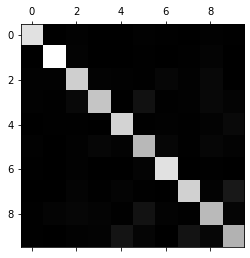

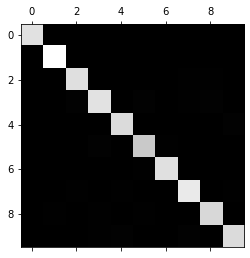

In [47]:
plt.matshow(conf_mx_sgd, cmap=plt.cm.gray)
plt.matshow(conf_mx_svm, cmap=plt.cm.gray)
plt.show()

The confusion matrix looks pretty good, since most images are on the main diagonal, which means that they were classified correctly. The 5s look slightly darker than the other digits, this which could mean that there are fewer images of 5s in the dataset or that the classifier does not perform as well on 5s as on other digits. We can verify that both are the case.

Let’s focus the plot on the errors. We need to divide each value in the confusion matrix by the number of images in the corresponding class so that we can compare error rates instead of absolute numbers of errors. Then we fill the diagonal with zeros to keep only the errors.

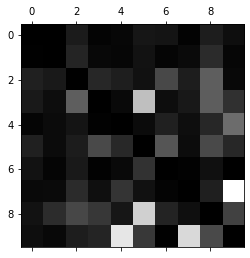

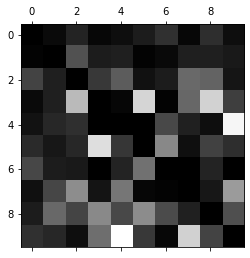

In [58]:
row_sums_sgd = conf_mx_sgd.sum(axis=1, keepdims=True)
norm_conf_mx_sgd = conf_mx_sgd / row_sums_sgd
np.fill_diagonal(norm_conf_mx_sgd, 0)

row_sums_svm = conf_mx_svm.sum(axis=1, keepdims=True)
norm_conf_mx_svm = conf_mx_svm / row_sums_svm
np.fill_diagonal(norm_conf_mx_svm, 0)

plt.matshow(norm_conf_mx_sgd, cmap=plt.cm.gray)
plt.matshow(norm_conf_mx_svm, cmap=plt.cm.gray)
plt.show()

You can see the kinds of errors the classifier makes. The column for class 8 is quite bright, which tells you that many images get misclassified as 8s. However, the row for class 8 is not that bad, telling you that actual 8s in general get properly classified as 8s. You can also see that 3s and 5s often get confused (in both directions).

Analyzing individual errors can also be a good way to gain insights on what
your classifier is doing and why it is failing, but it is more difficult and
time-consuming. 

For example, let’s plot examples of 3s and 5s.

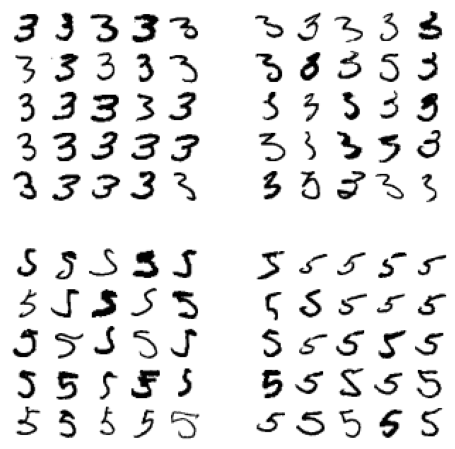

In [51]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")
    
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]
plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

The two blocks on the left show digits classified as 3s, and the two blocks on the right show images classified as 5s.  Some of the digits that the classifier gets wrong are so badly written that even a human would have trouble classifying them. However, most misclassified images seem like obvious errors to us, and it’s hard to understand why the classifier made the mistakes it did. The reason is that we used a simple SGDClassifier, which is a linear model. All it does is assign a weight per class to each pixel, and when it sees a new image it just sums up the weighted pixel intensities to get a score for each 3 class. So since 3s and 5s differ only by a few pixels, this model will easily confuse them.

### Multilabel Classification
Until now each instance has always been assigned to just one class. In some
cases you may want your classifier to **output multiple classes for each
instance**. 

Let’s look at a simple example. This code creates a y_multilabel array containing two target labels for each digit image: the first indicates whether or not the digit is large (7, 8, or 9), and the second indicates whether or not it is odd.

In [52]:
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

Then we create a **KNeighborsClassifier** (which supports multilabel classification) and we train it. Notice that it outputs two labels.

In [1]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)
print(knn_clf.predict([some_digit]))

NameError: name 'X_train' is not defined

There are many ways to evaluate a multilabel classifier, and selecting the right metric really depends on the project. One approach is to measure the F score for each individual label, then simply compute the average score. This assumes that all labels are equally important, however, which may not be the case. To do this, simply set average="weighted".

In [54]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
print(f1_score(y_multilabel, y_train_knn_pred, average="macro"))

0.976410265560605


### Multioutput Classification
It is a generalization of multilabel classification where **each label
can be multiclass** (i.e., it can have more than two possible values).

To illustrate this, we build a system that removes noise from images. It will take as input a noisy digit image, and it will output a clean digit image, represented as an array of pixel intensities. Notice that the classifier’s output is multilabel (one label per pixel) and each label can have multiple values (pixel intensity ranges from 0 to 255). 

Let’s start by creating the training and test sets by taking the MNIST images
and adding noise to their pixel intensities with NumPy’s **randint()**
function.

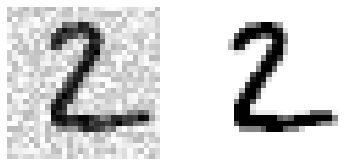

In [65]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
y_train_mod = X_train

noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_test_mod = X_test

def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")
    
some_index = 1
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
plt.show()

Now let’s train the classifier and make it clean this image.

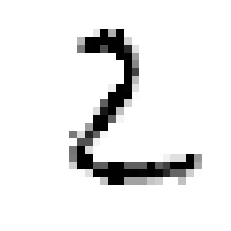

In [64]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)

## Exercise

**1. Try to build a classifier for the MNIST dataset that achieves over 97% accuracy on the test set. Hint: the KNeighborsClassifier works quite well for this task; you just need to find good hyperparameter values (try a grid search on the weights andn_neighbors hyperparameters).**

**Warning**: the next cell may take hours to run, depending on your hardware.

In [68]:
from sklearn.model_selection import GridSearchCV

param_grid = [{'weights': ["uniform", "distance"], 'n_neighbors': [3, 4, 5]}]

knn_clf = KNeighborsClassifier()
grid_search = GridSearchCV(knn_clf, param_grid, cv=5, verbose=3)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] n_neighbors=3, weights=uniform ..................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ...... n_neighbors=3, weights=uniform, score=0.972, total=11.7min
[CV] n_neighbors=3, weights=uniform ..................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 11.7min remaining:    0.0s


[CV] ...... n_neighbors=3, weights=uniform, score=0.971, total=12.2min
[CV] n_neighbors=3, weights=uniform ..................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 23.9min remaining:    0.0s


[CV] ...... n_neighbors=3, weights=uniform, score=0.969, total=12.1min
[CV] n_neighbors=3, weights=uniform ..................................
[CV] ...... n_neighbors=3, weights=uniform, score=0.969, total=11.9min
[CV] n_neighbors=3, weights=uniform ..................................
[CV] ...... n_neighbors=3, weights=uniform, score=0.970, total=11.9min
[CV] n_neighbors=3, weights=distance .................................
[CV] ..... n_neighbors=3, weights=distance, score=0.972, total=11.6min
[CV] n_neighbors=3, weights=distance .................................
[CV] ..... n_neighbors=3, weights=distance, score=0.972, total=11.3min
[CV] n_neighbors=3, weights=distance .................................
[CV] ..... n_neighbors=3, weights=distance, score=0.970, total=11.4min
[CV] n_neighbors=3, weights=distance .................................
[CV] ..... n_neighbors=3, weights=distance, score=0.970, total=11.6min
[CV] n_neighbors=3, weights=distance .................................
[CV] .

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 339.8min finished


GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': [3, 4, 5],
                          'weights': ['uniform', 'distance']}],
             verbose=3)

In [69]:
grid_search.best_params_

{'n_neighbors': 4, 'weights': 'distance'}

In [70]:
grid_search.best_score_

0.9716166666666666

In [71]:
from sklearn.metrics import accuracy_score

y_pred = grid_search.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.9714

**2 - Write a function that can shift an MNIST image in any direction (left, right, up, or down) by one pixel. Then, for each image in the training set, create four shifted copies (one per direction) and add them to the training set. Finally, train your best model on this expanded training set and measure its accuracy on the test set. You
should observe that your model performs even better now! This technique of artificially growing the training set is called data augmentation or training set expansion.**

In [72]:
from scipy.ndimage.interpolation import shift

In [73]:
def shift_image(image, dx, dy):
    image = image.reshape((28, 28))
    shifted_image = shift(image, [dy, dx], cval=0, mode="constant")
    return shifted_image.reshape([-1])

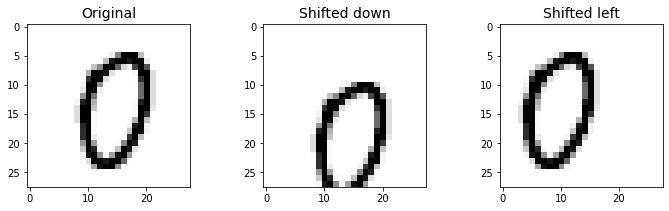

In [74]:
image = X_train[1000]
shifted_image_down = shift_image(image, 0, 5)
shifted_image_left = shift_image(image, -5, 0)

plt.figure(figsize=(12,3))
plt.subplot(131)
plt.title("Original", fontsize=14)
plt.imshow(image.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(132)
plt.title("Shifted down", fontsize=14)
plt.imshow(shifted_image_down.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(133)
plt.title("Shifted left", fontsize=14)
plt.imshow(shifted_image_left.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.show()

In [75]:
X_train_augmented = [image for image in X_train]
y_train_augmented = [label for label in y_train]

for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    for image, label in zip(X_train, y_train):
        X_train_augmented.append(shift_image(image, dx, dy))
        y_train_augmented.append(label)

X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

In [76]:
shuffle_idx = np.random.permutation(len(X_train_augmented))
X_train_augmented = X_train_augmented[shuffle_idx]
y_train_augmented = y_train_augmented[shuffle_idx]

In [77]:
knn_clf = KNeighborsClassifier(**grid_search.best_params_)

In [78]:
knn_clf.fit(X_train_augmented, y_train_augmented)

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [79]:
y_pred = knn_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9763

By simply augmenting the data, we got a 0.5% accuracy boost.